# Burst class for MINBAR

This notebook illustrates the use of a burst class for MINBAR and KEPLER models, including model-observation comparisons.  

The class definitions and related functions in the file burstclass.py, which can be imported as shown. First we define an observed burst, as well as a model burst, and then compare one to the other. You can get more information about the classes by using

    help (ObservedBurst)
    help (KeplerBurst)

Here we demonstrate the usage of the class.

4.177 h 0.01 h
1.1259999999999999e-06 erg / (cm2 s) 1.6e-08 erg / (cm2 s)
1.787 0.003


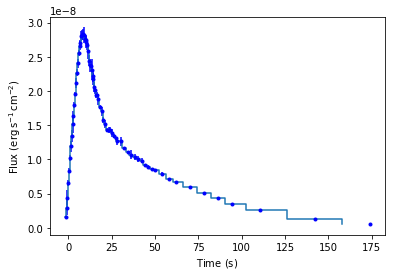

In [1]:
from burstclass import *

# Read in an observed burst

b = ObservedBurst('gs1826-24_4.177h.dat',path='../../burst/reference/')

# Show the recurrence time and other parameters, added from the .tex table

print (b.tdel,b.tdel_err)
print (b.fluen,b.fluen_err)
print (b.cbol,b.cbol_err)

# Here the plot method is inherited from the daughter class
# but doesn't work yet for the model burst class (because of the flux issue)

% matplotlib inline

# The plot is pretty basic for now

b.plot()

25 3.390000104904175 h 0.07999999821186066 h 0.082
<class 'burstclass.KeplerBurst'> gs1826-24_4.177h.dat kepler_a028_mean.txt
<class 'str'> <class 'str'>


-481.23392889577667

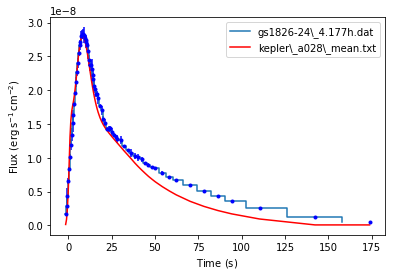

In [2]:
# Now also define a model burst. Note the difference in syntax

# c = ModelBurst('a005',path='../../reference')
c = KeplerBurst('a028',path='../../burst/reference')

# Show some of the class attributs, including the corrseponding table row;
# recurrence time and error; and the accretion rate
# Note that the plot method doesn't work yet

print (c.row,c.tdel,c.tdel_err,c.Lacc)
print (type(c), b.filename, c.filename)
print (type(b.filename), type(c.filename))

# Here we try to do a simple single-epoch comparison

#print (c.flux(6.*u.kpc))
b.compare(c,(6.1*u.kpc,60.*u.degree,1.28,-6.5*u.s),plot=True,subplot=False)

# Multiple burst comparisons

Here we demonstrate reading in multiple observed bursts, and matching them (as best as is possible) to the model bursts

In [3]:
# Assemble the observed bursts for GS 1826-24

path='../../burst/reference/'
b1 = ObservedBurst('gs1826-24_3.530h.dat',path=path)
b2 = ObservedBurst('gs1826-24_4.177h.dat',path=path)
b3 = ObservedBurst('gs1826-24_5.14h.dat',path=path)
obs = (b1,b2,b3)

# Calculate "target" ratios of mdot relative to b2; we want to find simulated
# bursts that have as close as possible the ratio of accretion rates,
# as do the observed bursts

t1 = b1.mdot/b2.mdot
t3 = b3.mdot/b2.mdot
print ("Mdot ratio targets: ",t1,t3)

# Define the model bursts. For the 4.177h burst, we already have a reasonable match with a028. 
# So need to get corresponding matches for the other two bursts

m2 = KeplerBurst('a028',path=path)

# Get the rows that match the same conditions for H-fraction and metallicity

same = np.where((m2.data['H'] == m2.data[m2.row]['H']) 
                & (m2.data['Z'] == m2.data[m2.row]['Z']))[0]
# print (same)

# And finally find the model with the closest ratio of accretion rates to our targets

acc_ratio = m2.data['Lacc']/m2.data[m2.row]['Lacc']
best1 = np.argmin(abs(acc_ratio[same]-t1))
print (same[best1], m2.data['Lacc'][same][best1],acc_ratio[same][best1], t1, m2.data['model'][same][best1])

best3 = np.argmin(abs(acc_ratio[same]-t3))
print (same[best3], m2.data['Lacc'][same][best3],acc_ratio[same][best3], t3, m2.data['model'][same][best3])

# According to this code, the best choice of model for m1 is a005, which has a Lacc of 0.1 (confirmed)
# Similarly, for m3, the best choice is a019

m1 = KeplerBurst('a005',path=path)
m3 = KeplerBurst('a019',path=path)

# And finally assemble the model burst tuple

models = (m1, m2, m3)

Mdot ratio targets:  1.1502890173410405 0.7413294797687862
2 0.1 1.21951 1.1502890173410405 b'a005'
16 0.067 0.817073 0.7413294797687862 b'a019'


In [4]:
# Now define a new likelihood function, based on the old one, but which can handle
# multiple pairs of observed bursts

# First define the prior

def lnprior(theta):
    dist, inclination, opz, t_off = theta

# We have currently flat priors for everything but the inclination, which
# has a probability distribution proportional to cos(i)

    if (dist.value > 0.0 and 0.0 < inclination.value < 90. 
        and 1. < opz < 2):
        return np.log(np.cos(inclination))
    
    return -np.inf
    
def apply_units(params,units = (u.kpc, u.degree, None, u.s)):
    
# When called from emcee, the parameters array might not have units. So 
# apply them here, in a copy of params (uparams)

    ok = True
    uparams = []
    for i, param in enumerate(params):
#        print (i,param,units[i])
        if units[i] != None:
            if hasattr(param,'unit') == False:
                uparams.append(param*units[i])
#                print ("Applying unit to element ",i)
            else:
                uparams.append(param)
                if param.unit != units[i]:
                    ok = False
        else:
            uparams.append(param)
            if hasattr(param,'unit') == True:
                ok = False
#    print (params, uparams, ok)
    assert(ok == True)
    
    return uparams

def lhoodClass(params,obs,model):
    '''
    Calculate the likelihood related to one or more model-observation comparisons
    The corresponding call to emcee will (necessarily) look something like this:

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lhoodClass, args=[obs, models ])    
    '''
    
    uparams = apply_units(params)
    
# We can pass multiple bursts, in which case we just loop over the function

    alh = 0.0

    if type(obs) == tuple:
        n = len(obs)
        if (n != len(model)):
            print ("** ERROR ** number of observed and model bursts don't match")
        
        for i in range(n):
            alh += lhoodClass(uparams,obs[i],model[i])
#            print (i,n,alh)

    else:
        
# Or if we have just one burst, here's what we do

        alh = obs.compare(model,uparams)
            
    return alh + lnprior(uparams) 

-447.65743019 -448.3505773703182


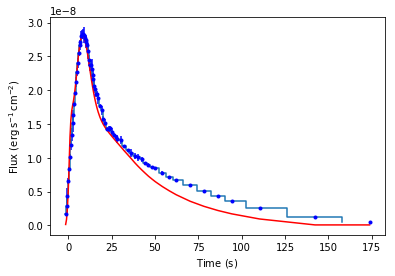

In [5]:
# Here some prelimiary testing of the lhoodClass function; this should 
# replicate the operation of the compare method for a single burst

params = (6.09*u.kpc,60.*u.degree,1.28,-6.5*u.s)

lh = b2.compare(m2,params,plot=True,subplot=False)
lh2 = lhoodClass(params,b2,m2)

# These should give the same results EXCEPT that the lhoodClass now
# includes a simple prior

print (lh,lh2)

In [6]:
# Now the real test, with a multiple burst comparison
# Can't yet do a plot here

params = (6.09*u.kpc,60.*u.degree,1.28,-6.5*u.s)

lh3 = lhoodClass(params,obs,models)
print ('Combined likelihood for all three models is ',lh3)

Combined likelihood for all three models is  -7185.063218319043


Since we've come this far, we might as well try to run emcee with the new lhoodClass routine. We define the parameters and initialise the walkers in a small ball around those values. Then we run the chains (for a modest numer of steps, at least initially)

In [7]:
import emcee

# emcee doesn't like parameters with units, so let's omit them for now
# I've tweaked lhoodClass to make sure they are re-applied prior to the
# likelihood calculation

params = (6.09,60.,1.28,-6.5)

ndim, nwalkers = len(params), 200
pos = [params*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

# Set up the walkers

# pos = []
# for i in range(nwalkers):
#     _params = [x*(1.+1e-4*np.random.randn()) for x in params]
#     pos.append(_params)
    
sampler = emcee.EnsembleSampler(nwalkers, ndim, lhoodClass, 
                                args=(obs,models))

print ("Running sampler...")
# %timeit -n 1 -r 1 pos_new, lnprob, rstate = sampler.run_mcmc(pos,20)
# 1 loop, best of 1: 2min 18s per loop (100 walkers)
pos_new, lnprob, rstate = sampler.run_mcmc(pos,20)

# ~8hr run
# pos_new, lnprob, rstate = sampler.run_mcmc(pos,1900)

print ("...done.")

Running sampler...
...done.


Now visualise the results

(2000, 4)


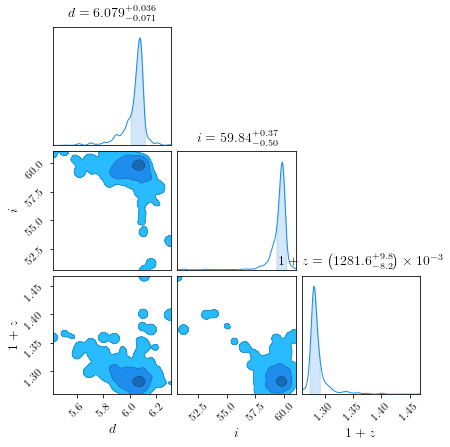

In [8]:
from chainconsumer import ChainConsumer

def plot_contours(sampler,parameters=[r"$d$",r"$i$",r"$1+z$"],ignore=10,plot_size=6):
# Documentation is here https://samreay.github.io/ChainConsumer/index.html

    samples = sampler.chain[:, ignore:, :].reshape((-1, ndim))
    print (np.shape(samples))

# This to produce a much more beautiful plot

    c = ChainConsumer()
    c.add_chain(samples, parameters = parameters)#,r"$\Delta t$"])


    fig = c.plot()
    fig.set_size_inches(6,6)
    
    return c

# Now try out the routine

c = plot_contours(sampler)

# Nice plot of the walks

# c.plot_walks()

Also want a set of code to visualise the model comparisons

Got parameter set for plotting:  [<Quantity 6.159809713217195 kpc>, <Quantity 51.26605414341181 deg>, 1.3734033231798382, <Quantity -6.450350259417149 s>]


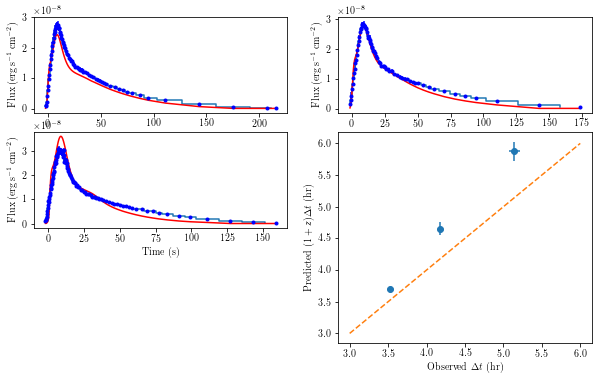

In [10]:
from matplotlib import gridspec

def plot_comparison(obs,models,param=None,sampler=None,ibest=None):

# Need to specify at least one of param, sampler

    assert ((param != None) | (sampler != None))
    
    if param == None:

# If no parameters are specified, try to get the best example
# from the sampler object

        if ibest == None:

# Identify the maximum probability set of parameters

            chain_shape = np.shape(sampler.lnprobability)
            imax = np.argmax(sampler.lnprobability)
            ibest = np.unravel_index(imax,chain_shape)

# print (imax,chain_shape,ibest)
        prob_max = sampler.lnprobability[ibest]
        _param_best = sampler.chain[ibest[0],ibest[1],:]

    else:
        
# Just use the supplied parameters

        _param_best = param
        
    param_best = apply_units(_param_best)
    print ('Got parameter set for plotting: ',param_best)

# Want to have a check here in case there are other than 3 models & obs 
# to compare

    n = len(obs)
    assert (n == 3)

    b1, b2, b3 = obs
    m1, m2, m3 = models
    
# See http://matplotlib.org/users/gridspec.html for documentation

    fig = plt.figure()
    gs = gridspec.GridSpec(3,2)

# plot the model comparisons. Should really do a loop here, but not sure
# exactly how

    ax1 = fig.add_subplot(gs[0,0])
    b1.compare(m1,param_best,plot=True,subplot=False)

    ax2 = fig.add_subplot(gs[0,1])
    b2.compare(m2,param_best,plot=True,subplot=False)

    ax3 = fig.add_subplot(gs[1,0])
    b3.compare(m3,param_best,plot=True,subplot=False)

# Now assemlbe the tdel values for plotting. This is a bit clumsy

    x = np.zeros(n)
    xerr = np.zeros(n)
    y = np.zeros(n)
    yerr = np.zeros(n)
    for i, burst in enumerate(obs):
        x[i] = burst.tdel.value
        xerr[i] = burst.tdel_err.value
        y[i] = models[i].tdel.value*param_best[2]
        yerr[i] = models[i].tdel_err.value*param_best[2]

#    print (x,xerr,y,yerr)
#    print (type(x))
#    print (type(b1.tdel),type(m1.tdel))

    ax4 = fig.add_subplot(gs[1:,-1])
    ax4.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
    ax4.plot([3,6],[3,6],'--')
    ax4.set_xlabel('Observed $\Delta t$ (hr)')
    ax4.set_ylabel('Predicted $(1+z)\Delta t$ (hr)')

    fig.set_size_inches(10,6)

# and let's try it out!

plot_comparison(obs,models,sampler=sampler)

In [18]:
print (b3.filename)

gs1826-24_5.14h.dat


# Incorporating mlfit.py

Here we want to modify Nathanael's mlfit.py code, to do the fitting, using the burst Class. The main focus is the routine lcCompare, which calls emcee. We ultimately want to run the comparison step in mlfit, which is invoked with something like this:

    params, uparams, ms, chisq, goodParams = lcCompare(burstFile,obsfile,plot=True)

The sequence is

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lhood, args=[modelFunc, x, y, dy, flatPriors, [cent,span] ])
    
where lhood is the likelihood function. So need to
* modify the lhood function to accept members of the burst class (both observed and modeled) as arguments

(This was my original idea; but I've since re-written modelFunc, and incorporated it into the compare method for the bursts. See above)

Remaining code below is for testing and development of the modelFunc function, now largely incorporated into the compare method

In [ ]:
import sys
sys.path.append('/Users/duncan/burst/reference')
from mlfit import *

# some of the routines in mlfit are defined only once you run lcCompare

# from the code segment above got observed burst b and model burst c

# Parameter array is now a tuple with the appropriate units:
# ( distance, burst anisotropy, redshift, time offset )

p = (6.*u.kpc,1.,1.,-8.*u.s)

test = modelFunc(p,b,c)
print (test)
print (len(test),len(b.time),len(c.time))
print (test.unit == b.flux.unit)

# Compare the observed burst and the interpolated, rescaled model burst

# plt.plot(c.time,c.lumin,b.time,test,'.')
b.plot()
plt.plot(b.time,test,'.')
# dir(mlfit)

# Random code snippets


91 (3, 91) (91,)
83.5 deg (0.56545735249216666, 0.023027982904217197, 0.10700591170743004) 1.69927768774 9.34527806963 (<Quantity 1.6307807551355935>, <Quantity 4.416835735998781>)
(<Quantity 1.6307807551355935>, <Quantity 4.416835735998781>) (1.6992776877378497, 9.3452780696280371)
** WARNING ** assuming inclination in degrees
(<Quantity 1.0>, <Quantity 0.9999999999999998>)


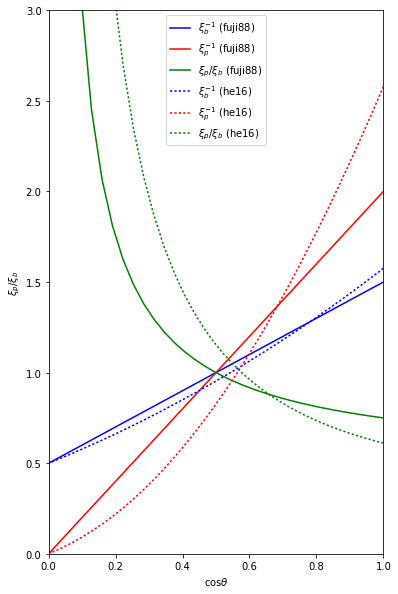

In [1]:
# Testing anisotropy.py

from anisotropy import *
from scipy.interpolate import interp1d

%matplotlib inline

a=ascii.read('anisotropy_he16.txt')
v=np.stack((a['col2'],a['col3'],a['col4']),axis=1).T
print (len(a['col1']),np.shape(v),np.shape(a['col1']))


# f = interp1d(a['col1'],a['col2'])
f = interp1d(a['col1'],v)
i_test = 83.5*u.degree
# print (83.5,f(83.5),anisotropy(83.5))
a, b, c = f(i_test)
print (i_test,(a,b,c),1./(a+b),1./c,anisotropy(i_test))

print (anisotropy(i_test),anisotropy(i_test,model='he16'))
print (anisotropy(60.,test=True))



In [ ]:
# You can test for the different kinds of objects in two ways:

if type(b) == ObservedBurst:
    print ('its an observed burst')

if isinstance(c,KeplerBurst):
    print ('we have a Kepler model burst')
#    print (c.data.columns)
    
# testing decode_LaTeX

val, val_err = decode_LaTeX('$ 34.3 \pm 0.2$')
print (val,val_err)
val, val_err = decode_LaTeX('34.3')
print (val,val_err)

print (float('34.3'))

In [ ]:
from astropy.table import Table

# Here we can read in a simplified version of the table from the burst reference
# paper, so that we can associate the burst parameters with each lightcurve file

file = '/Users/duncan/burst/reference/doc/table2.tex'
tab = Table.read(file)
#tab['col0']

# Below we associate each epoch with a file

file=['gs1826-24_5.14h.dat',
      'gs1826-24_4.177h.dat',
      'gs1826-24_3.530h.dat',
      'saxj1808.4-3658_16.55h.dat',
      'saxj1808.4-3658_21.10h.dat',
      'saxj1808.4-3658_29.82h.dat',
      '4u1820-303_2.681h.dat',
      '4u1820-303_1.892h.dat',
      '4u1636-536_superburst.dat']

tab['file'] = file

# Test here that you can identify each of these with a provided filename

filename='../../reference/gs1826-24_4.177h.dat'
# lcfile='gs1826-24_4.177h.dat'
# print (re.search(lcfile,filename))
for i, lcfile in enumerate(tab['file']):
#    m = re.match(lcfile,filename)
    m = re.search(lcfile,filename)
#    m = re.match('\$([0-9]+\.[0-9]+).pm([0-9]+\.[0-9]+)',tab['$\Delta t$ (hr)'][i])
#    print (m.group(1),m.group(2))
#    print ("'"+lcfile+"'",type(lcfile),type(filename),m)
    if m != None:
        row=i
        print (i, lcfile, filename)

print (tab['$\Delta t$ (hr)'][row])
print (type(tab['$\Delta t$ (hr)'][row]))
print (re.search('\$([0-9]+\.[0-9]+)',tab['$\Delta t$ (hr)'][row]).group(1))
print (re.search('pm([0-9]+\.[0-9]+)',tab['$\Delta t$ (hr)'][row]).group(1))

# print (re.match('','$4.177\pm0.010$'))
tab['$\Delta t$ (hr)']
print (tab.columns[5:10])
label = ['cbol','mdot','fluen','F_pk','alpha'

In [ ]:
from astroquery.vizier import Vizier

catalogs = Vizier.find_catalogs('Lampe')
for name, catalog in catalogs.items():
    print(name, ':', catalog.description)

model_table = Vizier.get_catalogs('J/ApJ/819/46')
row = (model_table[0]['model'] == b'a006')
print (type(model_table[0]['model']))

# row=(model_table[0]['model'].quantity == 'a005')
print (model_table[0][row])

print (model_table[0].columns)
print (model_table[0]['tDel'].unit)
print (model_table[0]['Lacc'].unit)



In [ ]:
# Here we learn how to extract information from the burst summary table

file='/Users/duncan/Documents/2015/Nat new catalog/summ.csv'
data = ascii.read(file)
print (type(data))
print (type(data['model']))# == 'xrba005'
match = np.where(data['model'] == "'xrba005'")
print (data['model'][match],data['tDel'][match]/3600.,data['uTDel'][match]/3600.)
print (data.columns)
